In [1]:
# @title Install dependencies: pytorch3d, point-cloud-utils, trimesh

import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])

!pip install fvcore iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
!pip install trimesh
!pip install point-cloud-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 272.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=c238acd843a7cce273ddf2d5421b9d972fe2a6ea7c8d73726415a0592e31d1e4
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=5cdad548ba0fa4ef111bbfd432ebc249874a2af8df15389ed1fc4a79f75eafb3
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt221/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.4/20.4 MB 180.0 MB/s eta 0:00:00
    

In [2]:
# @title Download the target mesh (Lego)

!wget https://polybox.ethz.ch/index.php/s/dxVoJKzYyCt7RCh/download -O lego_gt.obj

--2024-03-17 09:08:15--  https://polybox.ethz.ch/index.php/s/dxVoJKzYyCt7RCh/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156425997 (149M) [application/octet-stream]
Saving to: ‘lego_gt.obj’

lego_gt.obj         100%[===================>] 149.18M  23.6MB/s    in 7.2s    

2024-03-17 09:08:23 (20.8 MB/s) - ‘lego_gt.obj’ saved [156425997/156425997]



In [3]:
# @title Import libraries, define the necessary auxiliary functions (mesh normalisation, rendering, etc.)

import numpy as np
from tqdm import tqdm
import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    Textures,
    look_at_view_transform,
    FoVOrthographicCameras,
    Materials,
    RasterizationSettings,
    BlendParams,
    MeshRenderer,
    MeshRasterizer,
    AmbientLights,
    HardPhongShader,
)

# Constants for magic numbers
DEVICE = 'cuda'
DEFAULT_IMAGE_SIZE = 512
NUM_IMAGES = 100
DEFAULT_SCALE_VAL = 1.0
DEFAULT_RANDOM_SEED = 13

# to make sure the normals are between [0, 1]
def normals_to_rgb(normals: torch.Tensor) -> torch.Tensor:
    """
    Convert mesh normals to RGB color representation.

    Args:
        normals (torch.Tensor): Mesh normals.

    Returns:
        torch.Tensor: RGB colors based on the normals.
    """
    return torch.abs(normals * 0.5 + 0.5)

def get_normals_as_textures(mesh: Meshes) -> Meshes:
    """
    Create textures from mesh normals.

    Args:
        mesh (Meshes): Input mesh.

    Returns:
        Meshes: New mesh with normals as textures.
    """
    normals = mesh.verts_normals_packed()
    textures = Textures(verts_rgb=normals_to_rgb(normals).unsqueeze(0))
    return Meshes(mesh.verts_packed().unsqueeze(0), mesh.faces_packed().unsqueeze(0), textures)

def normalize_verts(vertices: torch.Tensor, scale=None, center=None) -> tuple:
    """
    Normalize vertex positions of a mesh.

    Args:
        vertices (torch.Tensor): Vertex positions.
        scale (float, optional): Scaling factor. Defaults to None.
        center (torch.Tensor, optional): Center of the mesh. Defaults to None.

    Returns:
        tuple: Normalized vertex positions, scaling factor, and center.
    """
    if scale is not None and center is not None:
        vertices = vertices - center
        vertices *= scale
    else:
        v_max, _ = torch.max(vertices, dim=0)
        v_min, _ = torch.min(vertices, dim=0)
        center = (v_max + v_min) / 2.
        vertices = vertices - center
        max_dist = torch.sqrt(torch.max(torch.sum(vertices**2, dim=-1)))
        scale = (1. / max_dist)
        vertices *= scale

    return vertices, scale, center

def normalize_mesh(mesh: Meshes, scale=None, center=None) -> tuple:
    """
    Normalize a mesh.

    Args:
        mesh (Meshes): Input mesh.
        scale (float, optional): Scaling factor. Defaults to None.
        center (torch.Tensor, optional): Center of the mesh. Defaults to None.

    Returns:
        tuple: Normalized mesh, scaling factor, and center.
    """
    vertices, scale, center = normalize_verts(mesh.verts_packed(), scale, center)
    normalized_mesh = mesh.update_padded(vertices.unsqueeze(0))
    return normalized_mesh, scale, center

def create_mesh_renderer(cameras, image_size=DEFAULT_IMAGE_SIZE, device='cuda'):
    """
    Create a mesh renderer.

    Args:
        cameras (FoVOrthographicCameras): Camera setup.
        image_size (int, optional): Image size. Defaults to DEFAULT_IMAGE_SIZE.
        device (str, optional): Device for computation. Defaults to 'cuda'.

    Returns:
        MeshRenderer: Mesh renderer.
    """
    materials = Materials(
        device=device,
        specular_color=[[0.0, 0.0, 0.0]],
        shininess=0.0
    )

    raster_settings = RasterizationSettings(
        image_size=image_size,
        blur_radius=0.0,
        faces_per_pixel=1,
        bin_size=None,
        cull_backfaces=True
    )

    blend_params = BlendParams(background_color=(0, 0, 0)) # to creat the color of the background of the mesh

    lights = AmbientLights(ambient_color=(1, 1, 1), device=device)

    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),

        shader=HardPhongShader(device=device,
                               cameras=cameras,
                               blend_params=blend_params,
                               lights=lights,
                               materials=materials)
    )

    return renderer

def render_mesh(mesh, dist=1, elev=0, azim=0,
                image_size=DEFAULT_IMAGE_SIZE, radius=0.01, scale_val=1.0,
                device=DEVICE):
    """
    Render a mesh.

    Args:
        mesh (Meshes): Input mesh.
        dist (float, optional): Distance from the camera. Defaults to 1.
        elev (float, optional): Elevation angle. Defaults to 0.
        azim (float, optional): Azimuth angle. Defaults to 0.
        image_size (int, optional): Image size. Defaults to DEFAULT_IMAGE_SIZE.
        radius (float, optional): Radius. Defaults to 0.01.
        scale_val (float, optional): Scaling value. Defaults to 1.0.
        device (str, optional): Device to use for rendering. Defaults to DEVICE.

    Returns:
        torch.Tensor: Rendered image.
    """
    R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim)
    cam = FoVOrthographicCameras(R=R, T=T, scale_xyz=((scale_val, scale_val, scale_val),)).to(device)

    renderer = create_mesh_renderer(cam, image_size=image_size)

    img = renderer(mesh, cameras=cam)[0]

    return img

def generate_render_data(mesh,
             n_images=NUM_IMAGES,
             scale_val=DEFAULT_SCALE_VAL,
             rand_seed=DEFAULT_RANDOM_SEED,
             image_size=DEFAULT_IMAGE_SIZE,
             device=DEVICE):
    """
    Generate rendering data.

    Args:
        mesh (Meshes): Input mesh.
        n_images (int, optional): Number of images to generate. Defaults to NUM_IMAGES.
        scale_val (float, optional): Scaling value. Defaults to DEFAULT_SCALE_VAL.
        rand_seed (int, optional): Random seed. Defaults to DEFAULT_RANDOM_SEED.
        image_size (int, optional): Image size. Defaults to DEFAULT_IMAGE_SIZE.
        device (str, optional): Device to use for rendering. Defaults to DEVICE.
    Returns:
        tuple: Azimuth angles, elevation angles, and rendered images.
    """
    np.random.seed(rand_seed)
    ygts = []
    azims, elevs = [], []

    for ix in tqdm(range(0, n_images)):
        azims.append(np.random.choice(360))
        elevs.append(np.random.choice(180))

        ygts.append(render_mesh(mesh.to(device),
                    azim=azims[ix],
                    elev=elevs[ix],
                    scale_val=scale_val,
                    image_size=image_size,
                    ).detach().cpu()[:, :, 0:3])

    np.random.seed(None)

    return azims, elevs, ygts

In [4]:
# Load and normalise GT mesh

GT_MESH_PATH = '/content/lego_gt.obj'

mesh_gt = load_objs_as_meshes([GT_MESH_PATH]).to(DEVICE)
mesh_gt = get_normals_as_textures(mesh_gt).to(DEVICE)
mesh_gt_norm, vscale, vcenter = normalize_mesh(mesh_gt)

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [5]:
# Generate renders of the GT mesh (used for training with image-space normal loss)

N_TRAIN_IMAGES = 500

azims_train, elevs_train,  ygts_train = generate_render_data(mesh_gt_norm,
                                 n_images=N_TRAIN_IMAGES,
                                 scale_val=1.0,
                                 rand_seed=19,
                                 image_size=DEFAULT_IMAGE_SIZE)

100%|██████████| 500/500 [04:12<00:00,  1.98it/s]


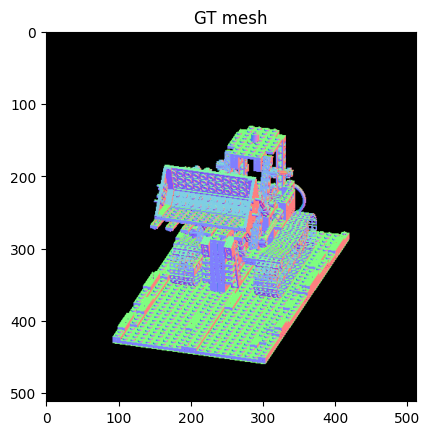

In [17]:
import matplotlib.pyplot as plt

# visualised GT mesh
plt.figure()
plt.title("GT mesh")
plt.imshow(ygts_train[np.random.choice(N_TRAIN_IMAGES)])
plt.savefig("GT_mesh.png")

In [ ]:
# @title Define functions for point rendering and optimisation

from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    PointsRasterizationSettings,
    PointsRasterizer,
    PointsRenderer,
    AlphaCompositor
)
from pytorch3d.loss import chamfer_distance

POINTS_PER_PIXEL = 50

def get_point_renderer(image_size, radius=0.05, points_per_pixel=50):

  raster_settings = PointsRasterizationSettings(
      image_size=image_size,
      radius = radius,
      points_per_pixel = points_per_pixel
      )

  rasterizer = PointsRasterizer(cameras=FoVOrthographicCameras(),
                                raster_settings=raster_settings)
  renderer = PointsRenderer(
      rasterizer=rasterizer,
      compositor=AlphaCompositor(background_color=(0, 0, 0))
  )

  return renderer

def render_points(x, xf, dist=1, elev=0, azim=0, image_size=512,
                  radius=0.01, points_per_pixel=50, scale_val=1.0,
                  device=DEVICE):

  x = x.to(device)
  xf = xf.to(device)
  renderer = get_point_renderer(image_size=image_size, radius=radius, points_per_pixel=points_per_pixel)
  R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim)
  cam = FoVOrthographicCameras(R=R, T=T, scale_xyz=((scale_val, scale_val, scale_val),)).to(device)

  pcl = Pointclouds(points=x.unsqueeze(0), features=xf.unsqueeze(0)).to(device)

  img = renderer(pcl, cameras=cam)[0]

  return img

In [19]:
# Sample initial points and corresponding normals

import point_cloud_utils as pcu

# uncomment the line for desired number of points and corresponding radius
# NUM_POINTS, POINT_RADIUS = 10**4, 0.025
# NUM_POINTS, POINT_RADIUS = 10**5, 0.009
NUM_POINTS, POINT_RADIUS = 3*10**5, 0.007
# NUM_POINTS, POINT_RADIUS = 10**6, 0.004

v0, n0 = sample_points_from_meshes(mesh_gt.to(DEVICE),
                   return_normals=True,
                   num_samples=NUM_POINTS)

v0 = torch.nn.Parameter(v0[0].clone().to(DEVICE), requires_grad=True)
n0 = torch.nn.Parameter(n0[0].clone().to(DEVICE), requires_grad=True)

# save the initial cloud for evaluation at the end
pcu.save_mesh_vn('dpf_init.ply', v0.detach().cpu().numpy(), n0.detach().cpu().numpy())

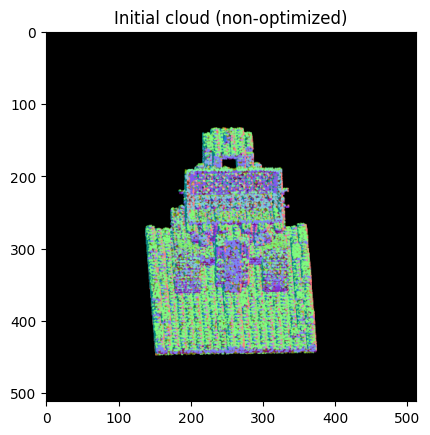

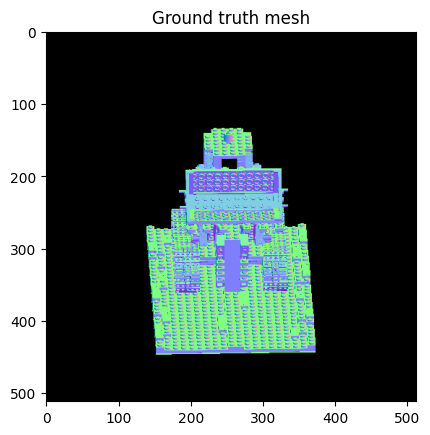

In [20]:
# render initial, non-optimised cloud
DEMO_FRAME_IX = np.random.choice(N_TRAIN_IMAGES)

v0_norm, _, _ = normalize_verts(v0, vscale, vcenter)

ypred_init = render_points(v0_norm.to(DEVICE),
              normals_to_rgb(n0.to(DEVICE)),
              elev=elevs_train[DEMO_FRAME_IX],
              azim=azims_train[DEMO_FRAME_IX],
              image_size=DEFAULT_IMAGE_SIZE,
              points_per_pixel=POINTS_PER_PIXEL,
              radius=POINT_RADIUS).detach().cpu().numpy()

ygt_demo = ygts_train[DEMO_FRAME_IX].detach().cpu().numpy()

plt.figure()
plt.title("Initial cloud (non-optimized)")
plt.imshow(ypred_init)
plt.savefig("ypred_init.png")

plt.figure()
plt.title("Ground truth mesh")
plt.imshow(ygt_demo)
plt.savefig("ygt_demo.png")

In [21]:
# @title Run point cloud optimisation

NUM_EPOCHS = 5
NUM_GT_EVAL_POINTS = 10**6
N_ITERS_PER_EPOCH = 50
vs = []
ns = []

mse_loss = torch.nn.MSELoss()

optv = torch.optim.Adam([v0], lr=1.0e-4)
optn = torch.optim.Adam([n0], lr=1.0e-2)

schedv = torch.optim.lr_scheduler.ReduceLROnPlateau(optv, verbose=True, patience=1)
schedn = torch.optim.lr_scheduler.ReduceLROnPlateau(optn, verbose=True, patience=1)

tloss = 0
n_r = 0

for i in tqdm(range(0, NUM_EPOCHS)):

  epoch_fids = np.random.choice(len(azims_train), N_ITERS_PER_EPOCH, replace=False)

  chamfer_loss_total = 0
  l2_norm_total = 0
  cosine_normal_loss_total = 0
  n_r = 0

  for ix in epoch_fids:

    vgt, vgtn = sample_points_from_meshes(mesh_gt.to(DEVICE),
                        return_normals=True,
                        num_samples=NUM_GT_EVAL_POINTS)

    v0_norm, _, _ = normalize_verts(v0, vscale, vcenter)
    ypred = render_points(v0_norm.to(DEVICE),
                normals_to_rgb(n0.to(DEVICE)),
                elev=elevs_train[ix],
                azim=azims_train[ix],
                image_size=DEFAULT_IMAGE_SIZE,
                points_per_pixel=POINTS_PER_PIXEL,
                radius=POINT_RADIUS)

    l2_norm = 10*mse_loss(ygts_train[ix].to(DEVICE), ypred)
    chamfer_loss, cosine_normal_loss = chamfer_distance(vgt, v0.unsqueeze(0), x_normals=vgtn, y_normals=n0.unsqueeze(0), norm=2)
    chamfer_loss, normal_loss = 10**4*chamfer_loss, cosine_normal_loss
    loss = chamfer_loss + cosine_normal_loss + 10*l2_norm

    chamfer_loss_total += float(chamfer_loss)
    cosine_normal_loss_total += float(cosine_normal_loss)
    l2_norm_total += float(l2_norm)
    n_r += 1
    optv.zero_grad()
    optn.zero_grad()
    loss.backward()
    optv.step()
    optn.step()




  chamfer_loss_total /= n_r
  l2_norm_total /= n_r
  cosine_normal_loss_total /= n_r
  print("Chamfer loss: %f, cosine normal loss: %f,  L2 image normal loss: %f" % (chamfer_loss_total, cosine_normal_loss_total, l2_norm_total))
  total_loss = chamfer_loss_total + l2_norm_total
  schedv.step(float(total_loss))
  schedn.step(float(total_loss))

  # save the optimisation model
  torch.save({
    'epoch': i,
    'v0': v0.data,
    'n0': n0.data,
    'optv_state_dict': optv.state_dict(),
    'optn_state_dict': optn.state_dict(),
    'loss': total_loss,
  }, f'model_checkpoint_epoch_{i}.pth')


 20%|██        | 1/5 [03:08<12:35, 188.94s/it]

Chamfer loss: 0.486824, cosine normal loss: 0.435868,  L2 image normal loss: 0.141271


 40%|████      | 2/5 [06:18<09:27, 189.06s/it]

Chamfer loss: 0.447173, cosine normal loss: 0.383396,  L2 image normal loss: 0.089397


 60%|██████    | 3/5 [09:27<06:18, 189.12s/it]

Chamfer loss: 0.433999, cosine normal loss: 0.372842,  L2 image normal loss: 0.070130


 80%|████████  | 4/5 [12:36<03:09, 189.25s/it]

Chamfer loss: 0.428106, cosine normal loss: 0.371919,  L2 image normal loss: 0.065289


100%|██████████| 5/5 [15:45<00:00, 189.17s/it]

Chamfer loss: 0.425655, cosine normal loss: 0.373256,  L2 image normal loss: 0.059053


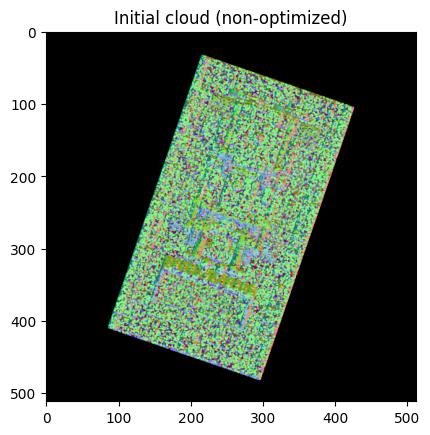

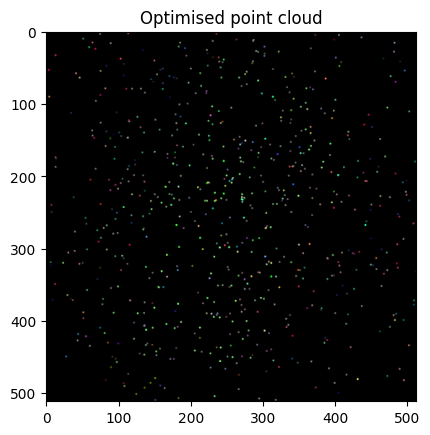

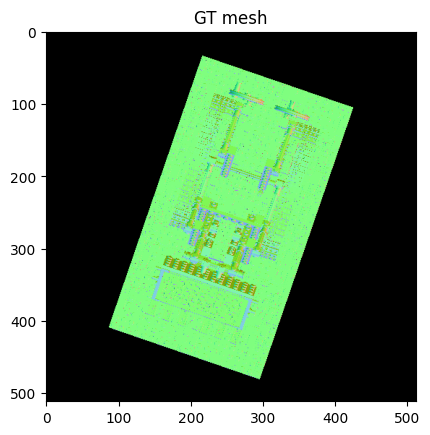

In [15]:
# Render the optimised cloud

ypred = render_points(v0_norm.to(DEVICE),
            normals_to_rgb(n0.to(DEVICE)),
            elev=elevs_train[DEMO_FRAME_IX],
            azim=azims_train[DEMO_FRAME_IX],
            image_size=DEFAULT_IMAGE_SIZE,
            points_per_pixel=POINTS_PER_PIXEL,
            radius=POINT_RADIUS)

plt.figure()
plt.title("Initial cloud (non-optimized)")
plt.imshow(ypred_init)
plt.savefig("initial.png")

plt.figure()
plt.title("Optimised point cloud")
plt.imshow(ypred.detach().cpu().numpy())
plt.savefig("optimised.png")

plt.figure()
plt.title("GT mesh")
plt.imshow(ygts_train[DEMO_FRAME_IX][:, :, 0:3].detach().cpu().numpy())
plt.savefig("GT.png")

In [ ]:
# @title Define functions for surface reconstruction

import torch
from pytorch3d.io import IO
from scipy.stats import sem
import point_cloud_utils as pcu

device = 'cuda'

def chamfer_eval(x, y, xn, yn, verbose=False):
    """
    Compute the chamfer distance and cosine normals between two point sets.

    Args:
        x (torch.Tensor): The first set of points (B x N x 3).
        y (torch.Tensor): The second set of points (B x M x 3).
        xn (torch.Tensor): The normals of the first set of points (B x N x 3).
        yn (torch.Tensor): The normals of the second set of points (B x M x 3).
        verbose (bool): If True, print the computed chamfer distances and cosine normals.

    Returns:
        torch.Tensor: The chamfer distance between x and y (B).
        torch.Tensor: The cosine normals between xn and yn (B).
    """
    l2_chamfer, l2_normals = chamfer_distance(x, y, x_normals=xn, y_normals=yn, norm=2)
    l2_chamfer, l2_normals = (10**4) * l2_chamfer, l2_normals

    if verbose:
        print("Chamfer L2 (x 10^-4): %f, Chamfer Cosine Normals: %f" %
              (float(l2_chamfer), float(l2_normals)))

    return l2_chamfer, l2_normals


def eval_surface_reconstruction_cloud(pred_cloud_path, gt_mesh_path, n_samples=10**6, device='cuda'):
    """
    Evaluate the surface reconstruction performance for a point cloud and a mesh.

    Args:
        pred_cloud_path (str): The file path to the predicted point cloud.
        gt_mesh_path (str): The file path to the ground truth mesh.
        n_samples (int): The number of points to sample from the mesh. Defaults to 10^6.
        device (str): The device to perform computations on. Defaults to 'cuda'.

    Returns:
        torch.Tensor: The chamfer distance between predicted point cloud and ground truth mesh.
        torch.Tensor: The cosine normals between predicted point cloud and ground truth mesh.
    """
    gt_mesh = IO().load_mesh(gt_mesh_path, device=device)

    pred_points, pred_normals = pcu.load_mesh_vn(pred_cloud_path)
    pred_points = torch.Tensor(pred_points).unsqueeze(0).to(device)
    pred_normals = torch.Tensor(pred_normals).unsqueeze(0).to(device)

    gt_points, gt_normals = sample_points_from_meshes(gt_mesh, return_normals=True, num_samples=n_samples)

    l2_chamfer, l2_normals = chamfer_eval(gt_points, pred_points, gt_normals, pred_normals, verbose=True)

    return l2_chamfer, l2_normals


In [ ]:
# Save the optimised cloud, evaluate
pcu.save_mesh_vn('dpf_optimised.ply', v0.detach().cpu().numpy(), n0.detach().cpu().numpy())

print("*******RESULTS Non-Optimised Cloud ******")
eval_surface_reconstruction_cloud('/content/dpf_init.ply', '/content/lego_gt.obj')

print("*******RESULTS Optimised Cloud ******")
eval_surface_reconstruction_cloud('/content/dpf_optimised.ply', '/content/lego_gt.obj')

*******RESULTS Non-Optimised Cloud ******


/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


Chamfer L2 (x 10^-4): 0.536437, Chamfer Cosine Normals: 0.470831
*******RESULTS Optimised Cloud ******
Chamfer L2 (x 10^-4): 0.423045, Chamfer Cosine Normals: 0.373875


(tensor(0.4230, device='cuda:0'), tensor(0.3739, device='cuda:0'))